# Diamonds - Machine Learning Project

#### Importing the necessary libraries and define formulas:

In [492]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [493]:
def colum_calcs(df):
    df['volume'] = (df['x'] * df['y'] * df['z'])
    df['ratio_xy'] = df['x'] / df['y']

In [494]:
def diamond_shape(df):
    dshape = []
    for i in df['table'].index:
        if 54<df['table'][i]<57 and 61<df['depth'][i]<62.5:
            dshape.append('round')
        elif 52<df['table'][i]<60 and 60<df['depth'][i]<68:
            dshape.append('oval')
        elif 63<df['table'][i]<69 and 69<df['depth'][i]<76:
            dshape.append('princess')
        elif 58<df['table'][i]<63 and 58<df['depth'][i]<66:
            dshape.append('cushion')
        else:
            dshape.append('others')
    return dshape

In [495]:
def convertfeatures2log(df, listvars):
    for var in listvars:
        df[var] = np.log(df[var])

In [496]:
def convert_catg(df):
    df['cut'] = df['cut'].map({'Fair':0,'Good':1,'Very Good':2,'Premium':3, 'Ideal':4})
    df['color'] = df['color'].map({'J':0, 'I':1, 'H':2, 'G':3, 'F': 4, 'E': 5, 'D':6})
    df['clarity'] = df['clarity'].map({'I1':0,'SI2':1,'SI1':2,'VS2':3,'VS1':4,'VVS2':5,'VVS1':6,'IF':7})
    df['shape'] = df['shape'].map({'round':4, 'oval': 1, 'princess': 3, 'cushion':2, 'others':0})

#### Import the tables

In [497]:
diamonds = pd.read_csv('data/diamonds_train.csv')
diamonds_predict = pd.read_csv('data/diamonds_test.csv')

## Exploratory Data Analysis

In [498]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797706,61.752841,57.446133,3928.444469,5.729392,5.732819,3.537154
std,0.475544,1.431725,2.233535,3992.416147,1.124453,1.146650,0.697062
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2397.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5331.000000,6.540000,6.540000,4.035000
max,4.500000,79.000000,95.000000,18823.000000,10.230000,58.900000,8.060000


There are zero values in x, y and z, plus it seems like there are big outliers there. We'll have to take care of that.

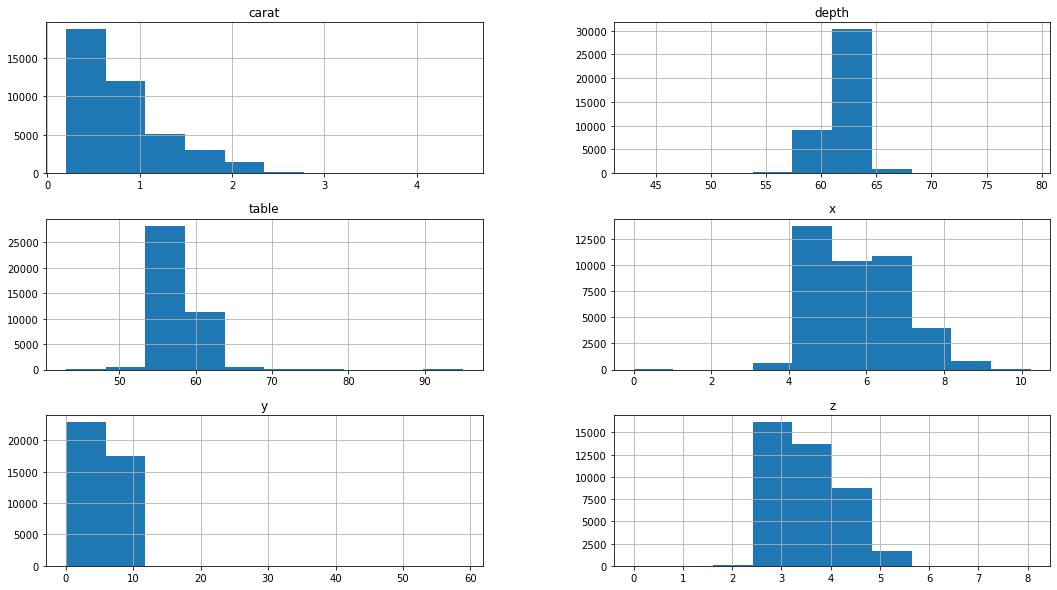

In [499]:
linear_vars = ['carat','depth','table','x','y','z']
diamonds.hist(linear_vars, figsize=(18,10));

As it can be seen, there are outliers and the shape of the distribution is not normalized.

## Data Treatment

In [500]:
diamonds.drop_duplicates(inplace=True)

In [501]:
diamonds = diamonds_clean = diamonds[(diamonds[['x','y', 'z']] != 0).all(axis=1)]
diamonds = diamonds.loc[~((diamonds['y'] > 20) | (diamonds['z'] > 10))]

In [502]:
colum_calcs(diamonds)

In [503]:
diamonds.describe()

,carat,depth,table,price,x,y,z,volume,ratio_xy
count,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000
mean,0.797305,61.752476,57.446699,3927.129467,5.729638,5.731713,3.538472,129.749271,0.999407
std,0.474716,1.430860,2.233382,3989.310209,1.121648,1.113421,0.692841,76.617237,0.010364
min,0.200000,43.000000,43.000000,326.000000,3.770000,3.720000,1.070000,32.262375,0.749169
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000,64.973466,0.992593
50%,0.700000,61.800000,57.000000,2397.500000,5.690000,5.710000,3.520000,114.725487,0.995726
75%,1.040000,62.500000,59.000000,5330.000000,6.540000,6.540000,4.030000,170.844626,1.006928
max,4.500000,79.000000,95.000000,18823.000000,10.230000,10.160000,6.720000,698.455296,1.615572


In [504]:
diamonds['shape'] = diamond_shape(diamonds)

In [505]:
linear_vars = ['carat']
convertfeatures2log(diamonds, linear_vars)

In [506]:
convert_catg(diamonds)

In [507]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy,shape
0,0.190620,3,0,3,62.4,58.0,4268,6.83,6.79,4.25,197.096725,1.005891,1
1,-1.139434,2,2,3,63.0,57.0,505,4.35,4.38,2.75,52.395750,0.993151,1
2,-0.342490,0,3,4,65.5,55.0,2686,5.62,5.53,3.65,113.436890,1.016275,1
3,-0.891598,1,6,2,63.8,56.0,738,4.68,4.72,3.00,66.268800,0.991525,1
4,0.019803,4,3,2,60.5,59.0,4882,6.55,6.51,3.95,168.429975,1.006144,1


In [508]:
diamonds.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy,shape
count,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000,40350.000000
mean,-0.396388,2.904659,3.401140,3.050781,61.752476,57.446699,3927.129467,5.729638,5.731713,3.538472,129.749271,0.999407,1.672193
std,0.585684,1.117679,1.701388,1.647601,1.430860,2.233382,3989.310209,1.121648,1.113421,0.692841,76.617237,0.010364,1.227449
min,-1.609438,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,3.770000,3.720000,1.070000,32.262375,0.749169,0.000000
25%,-0.916291,2.000000,2.000000,2.000000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000,64.973466,0.992593,1.000000
50%,-0.356675,3.000000,3.000000,3.000000,61.800000,57.000000,2397.500000,5.690000,5.710000,3.520000,114.725487,0.995726,1.000000
75%,0.039221,4.000000,5.000000,4.000000,62.500000,59.000000,5330.000000,6.540000,6.540000,4.030000,170.844626,1.006928,2.000000
max,1.504077,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,10.230000,10.160000,6.720000,698.455296,1.615572,4.000000


## Model Training

In [509]:
scaler = StandardScaler()

In [510]:
NUM_FEATS = ['ratio_xy','carat','volume',]
CAT_FEATS = ['cut', 'color', 'clarity','shape']
FEATS = NUM_FEATS + CAT_FEATS
TARGET = 'price'

In [511]:
X = scaler.fit_transform(diamonds[FEATS])
y = diamonds[TARGET]

In [512]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [513]:
model = lgb.LGBMRegressor()

In [514]:
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error',cv=10)

In [515]:
np.mean(-scores)

519.3088695219061

In [516]:
param_grid = {
    'num__imputer__strategy': ['mean', 'median'],
    'n_estimators': [55, 64, 68],
    'max_depth': [8],
    'num_leaves' : [92, 95, 97],
    'learning_rate' : [0.005, 0.1,0.2],
    'max_bin': [495,500,512],
    
}


grid_search = GridSearchCV(model, 
                           param_grid=param_grid,
                           cv=10, 
                           verbose=3, 
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

In [517]:
grid_search.fit(X, y)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[LightGBM] [Warning] Unknown parameter: num__imputer__strategy


GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.1, 0.2],
                         'max_bin': [495, 500, 512], 'max_depth': [8],
                         'n_estimators': [55, 64, 68],
                         'num__imputer__strategy': ['mean', 'median'],
                         'num_leaves': [92, 95, 97]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [518]:
grid_search.best_estimator_

LGBMRegressor(max_bin=500, max_depth=8, n_estimators=64,
              num__imputer__strategy='mean', num_leaves=92)

In [519]:
grid_search.best_score_


-515.057399252451

In [520]:
model.fit(X_train,y_train)

LGBMRegressor()

In [521]:
prediction = grid_search.predict(X_test)

In [522]:
mae = mean_absolute_error(y_test,prediction)
print("mae: %f" %(mae))
Rsquare = model.score(X_test,y_test)
print("Rsquare: %f" %(Rsquare))
rmse = np.sqrt(mean_squared_error(y_test,prediction))
print("rmse: %f" %(rmse))

mae: 241.432244
Rsquare: 0.982492
rmse: 464.033204


## Prediction

In [436]:
diamonds_predict['x'] = diamonds_predict['x'].apply(lambda x: diamonds_predict['x'].median() if x==0 else x)
diamonds_predict['y'] = diamonds_predict['y'].apply(lambda x: diamonds_predict['y'].median() if x==0 else x)
diamonds_predict['z'] = diamonds_predict['z'].apply(lambda x: diamonds_predict['z'].median() if x==0 else x)

In [437]:
colum_calcs(diamonds_predict)
diamonds_predict['shape'] = diamond_shape(diamonds_predict)
convertfeatures2log(diamonds_predict, linear_vars)
convert_catg(diamonds_predict)

In [438]:
diamonds_predict.describe()

,id,carat,cut,color,clarity,depth,table,x,y,z,volume,ratio_xy,shape
count,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000
mean,6742.000000,-0.391288,2.902039,3.420912,3.055914,61.739095,57.490337,5.737722,5.740920,3.544521,130.028155,0.999518,1.670745
std,3892.928525,0.580873,1.112801,1.700614,1.644048,1.435310,2.237109,1.110378,1.125255,0.728452,76.205426,0.012935,1.225051
min,0.000000,-1.609438,0.000000,0.000000,0.000000,50.800000,51.000000,3.730000,3.680000,1.410000,31.707984,0.161950,0.000000
25%,3371.000000,-0.916291,2.000000,2.000000,2.000000,61.000000,56.000000,4.730000,4.730000,2.920000,65.663752,0.992669,1.000000
50%,6742.000000,-0.356675,3.000000,3.000000,3.000000,61.900000,57.000000,5.700000,5.720000,3.530000,115.136440,0.995781,1.000000
75%,10113.000000,0.039221,4.000000,5.000000,4.000000,62.500000,59.000000,6.530000,6.530000,4.040000,170.791400,1.006993,2.000000
max,13484.000000,1.611436,4.000000,6.000000,7.000000,79.000000,73.000000,10.740000,31.800000,31.800000,838.502400,1.601415,4.000000


In [439]:
X_test = scaler.transform(diamonds_predict[FEATS])

In [440]:
preds = grid_search.predict(X_test)

In [441]:
output = pd.DataFrame({'id': diamonds_predict['id'], 'price': preds})

In [442]:
output.head()

,id,price
0,0,2886.280205
1,1,5685.350291
2,2,9545.457913
3,3,4060.584000
4,4,1610.545833


In [343]:
output.to_csv('submission.csv',index=False)